In [1]:
from copy import deepcopy
import os
import random
import sys

In [2]:
from matplotlib.ticker import PercentFormatter
from torch.utils.data import Dataset, DataLoader, random_split
from torchdata import datapipes as DataPipe
from tqdm.notebook import tqdm
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import scipy.optimize as SciOpt
import toml
import torch
import torch.nn as nn
import torch.nn.functional as F

pd.set_option('display.float_format', lambda x: f'{x:,.2f}')
pd.set_option('display.precision', 2)

In [3]:
sys.path.append(os.path.join(sys.path[0], '../..'))

from endure.data.io import Reader
from endure.lcm.model.builder import LearnedCostModelBuilder, ClassicModel, FlexibleModel
from endure.lcm.data.generator import ClassicGenerator
from endure.ltune.data.generator import LTuneGenerator
from endure.lsm.types import Policy, LSMDesign, System
from endure.lsm.cost import EndureCost
import endure.lsm.cost_model as CostFunc

In [4]:
config = Reader.read_config('../../endure.toml')

In [5]:
model_path = '/data/models/lcm/classic-05-19-v0/'
model_type = 'Classic'
config_model = Reader.read_config(os.path.join(model_path, 'endure.toml'))

In [6]:
gen = ClassicGenerator(config_model)
cf = EndureCost(config)

# Loss Graph

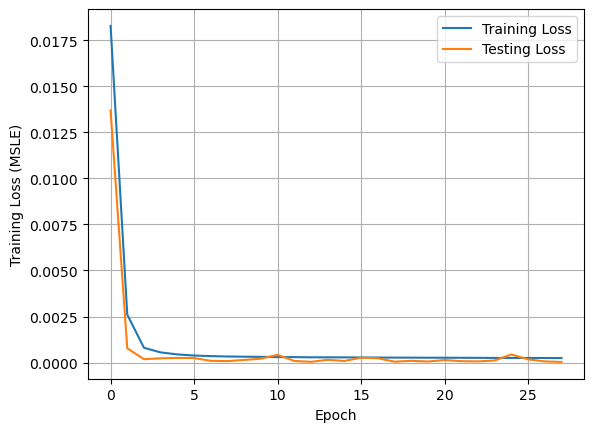

In [7]:
losses = pd.read_csv(os.path.join(model_path, 'losses.csv'))
fig, ax = plt.subplots()
ax.plot(losses['epoch'], losses['train_loss'], label='Training Loss')
ax.plot(losses['epoch'], losses['test_loss'], label='Testing Loss')
ax.set_xlabel('Epoch')
ax.set_ylabel(f'Training Loss ({config_model["job"]["LCMTrain"]["loss_fn"]})')
# ax.set_yscale('log')
ax.grid()
_ = ax.legend()

# Building

## Model

In [8]:
model_name = os.path.join(model_path, 'best.model')
# model_name = os.path.join(model_path, 'checkpoints/epoch_20.checkpoint')
# last_checkpoint = os.listdir(os.path.join(model_path, 'checkpoints'))[-1]
# model_name = os.path.join(model_path, 'checkpoints', last_checkpoint)

builder = LearnedCostModelBuilder(config_model)
model = builder.build_model()
model_data = torch.load(model_name)
model_params = model_data['model_state_dict'] if model_name.endswith('checkpoint') else model_data
load_status = model.load_state_dict(model_params)
model.eval()
load_status

<All keys matched successfully>

In [9]:
model

ClassicModel(
  (embedding): Sequential(
    (0): Linear(in_features=49, out_features=128, bias=True)
  )
  (cost_layer): Sequential(
    (0): BatchNorm1d(139, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (1): Linear(in_features=139, out_features=512, bias=True)
    (2): Dropout(p=0, inplace=False)
    (3): LeakyReLU(negative_slope=0.01)
    (4): Linear(in_features=512, out_features=512, bias=True)
    (5): Dropout(p=0, inplace=False)
    (6): LeakyReLU(negative_slope=0.01)
    (7): Linear(in_features=512, out_features=512, bias=True)
    (8): Dropout(p=0, inplace=False)
    (9): LeakyReLU(negative_slope=0.01)
    (10): Linear(in_features=512, out_features=512, bias=True)
    (11): Dropout(p=0, inplace=False)
    (12): LeakyReLU(negative_slope=0.01)
    (13): Linear(in_features=512, out_features=4, bias=True)
    (14): LeakyReLU(negative_slope=0.01)
  )
)

# Utils

In [10]:
def to_array(workload: dict):
    return np.array([workload[x] for x in ('z0', 'z1', 'q', 'w')])

In [11]:
def l2_norm(a, b):
    return np.linalg.norm((a, b), 2)

In [12]:
def eval_lcm(design, system, z0, z1, q, w):
    categories = config['lsm']['size_ratio']['max'] - config['lsm']['size_ratio']['min'] + 1
    T = design.T - config['lsm']['size_ratio']['min']
    T = np.eye(categories, dtype=np.int32)[T]
    feats = [z0, z1, q, w, system.B, system.s, system.E, system.H, system.N, design.policy.value, design.h]
    if "policy" not in config["lcm"]["input_features"]:
        feats.pop(-2)
    inputs = np.concatenate((np.array(feats), T))
    inputs = torch.from_numpy(inputs).to(torch.float).view(1, -1)
    with torch.no_grad():
        pred = model(inputs)
        pred = pred.sum().item()
    return pred

In [13]:
wl = (z0, z1, q, w) = gen._sample_workload(4)
system = gen._sample_system()
design = gen._sample_design(system)
cf.calc_cost(design, system, z0, z1, q, w), eval_lcm(design, system, z0, z1, q, w)

(1.2864943402646616, 1.2615909576416016)

## Learned-Cost-Model Estimation To Analytical

### Single Variable Estimation

In [14]:
def generate_single_var_estimation(wl, system=None):
    if system is None:
        system = System()
    (z0, z1, q, w) = wl
    table = []
    design = LSMDesign(h=2, T=10, policy=Policy.Tiering)
    # for val in tqdm(np.arange(2, 50, 1)):
    #     design.T = val
    for val in tqdm(np.arange(0, 9, 0.1)):
        design.h = val
        cost_lcm = eval_lcm(design, system, z0, z1, q, w)
        cost_acm = cf.calc_cost(design, system, z0, z1, q, w)
        row = {
            "z0": z0,
            "z1": z1,
            "q": q,
            "w": w,
            "B": system.B,
            "s": system.s,
            "E": system.E,
            "H": system.H,
            "N": system.N,
            'h': design.h,
            "policy": 1 if design.policy == Policy.Leveling else 0,
            'T': design.T,
            "cost_lcm": cost_lcm,
            "cost_acm": cost_acm,
        }
        table.append(row)
    table = pd.DataFrame(table)
    
    return table

In [15]:
idx = 8
df = generate_single_var_estimation(to_array(config['workloads'][idx]))

  0%|          | 0/90 [00:00<?, ?it/s]

In [16]:
df['delta'] = abs(df['cost_acm'] - df['cost_lcm'])
df['norm_delta'] = df['delta'] / df['cost_acm']
df.sort_values(by='norm_delta', ascending=False)
df.describe()

,z0,z1,q,w,B,s,E,H,N,h,policy,T,cost_lcm,cost_acm,delta,norm_delta
count,90.00,90.00,90.00,90.00,90.00,90.00,90.00,90.00,90.00,90.00,90.00,90.00,90.00,90.00,90.00,90.00
mean,0.01,0.49,0.49,0.01,4.00,0.00,"8,192.00",10.00,"1,000,000,000.00",4.45,0.00,10.00,29.01,27.71,1.30,0.05
std,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,2.61,0.00,0.00,0.74,0.73,0.10,0.00
min,0.01,0.49,0.49,0.01,4.00,0.00,"8,192.00",10.00,"1,000,000,000.00",0.00,0.00,10.00,28.32,26.99,1.07,0.04
25%,0.01,0.49,0.49,0.01,4.00,0.00,"8,192.00",10.00,"1,000,000,000.00",2.23,0.00,10.00,28.45,27.10,1.30,0.05
50%,0.01,0.49,0.49,0.01,4.00,0.00,"8,192.00",10.00,"1,000,000,000.00",4.45,0.00,10.00,28.72,27.47,1.34,0.05
75%,0.01,0.49,0.49,0.01,4.00,0.00,"8,192.00",10.00,"1,000,000,000.00",6.68,0.00,10.00,29.39,28.12,1.36,0.05
max,0.01,0.49,0.49,0.01,4.00,0.00,"8,192.00",10.00,"1,000,000,000.00",8.90,0.00,10.00,31.17,29.88,1.38,0.05


{'id': 8, 'z0': 0.01, 'z1': 0.49, 'q': 0.49, 'w': 0.01}

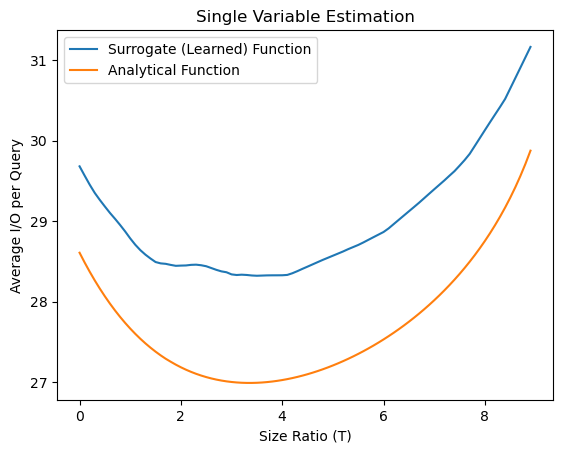

In [17]:
x = df['h']
y_learned = df['cost_lcm']
y_analytical = df['cost_acm']

fig, ax = plt.subplots()
ax.plot(x, y_learned, label='Surrogate (Learned) Function')
ax.plot(x, y_analytical, label='Analytical Function')
ax.set_xlabel('Size Ratio (T)')
ax.set_ylabel('Average I/O per Query')
ax.set_title('Single Variable Estimation')
ax.legend()
config_model['workloads'][idx]

### Random Configuration Estimation

In [18]:
def generate_random_samples(num_samples=100):
    table = []
    for _ in tqdm(range(num_samples)):
        z0, z1, q, w = gen._sample_workload(4)
        system = gen._sample_system()
        design = gen._sample_design(system, policies=[Policy.Tiering, Policy.Leveling])
        cost_lcm = eval_lcm(design, system, z0, z1, q, w)
        cost_acm = cf.calc_cost(design, system, z0, z1, q, w)
        row = {
            "z0": z0,
            "z1": z1,
            "q": q,
            "w": w,
            "B": system.B,
            "s": system.s,
            "E": system.E,
            "H": system.H,
            "N": system.N,
            'h': design.h,
            "policy": 1 if design.policy == Policy.Leveling else 0,
            'T': design.T,
            "cost_lcm": cost_lcm,
            "cost_acm": cost_acm,
        }
        table.append(row)
    table = pd.DataFrame(table)
    
    return table

In [19]:
num_samples = 10000
df = generate_random_samples(num_samples)

  0%|          | 0/10000 [00:00<?, ?it/s]

In [20]:
df['delta'] = df['cost_acm'] - df['cost_lcm']
df['norm_delta'] = df['delta'] / df['cost_acm']
df.sort_values(by='norm_delta', ascending=False)

,z0,z1,q,w,B,s,E,H,N,h,policy,T,cost_lcm,cost_acm,delta,norm_delta
180,0.00,0.18,0.79,0.02,64.00,0.00,2048,10.01,863906634,9.91,0,32,72.22,78.39,6.17,0.08
4622,0.05,0.01,0.76,0.18,128.00,0.00,1024,10.76,892115935,10.65,0,21,45.44,48.80,3.36,0.07
4535,0.18,0.10,0.01,0.71,8.00,0.00,4096,19.24,636364236,17.12,0,31,1.39,1.49,0.10,0.07
2860,0.65,0.24,0.00,0.11,32.00,0.00,4096,10.66,758356528,10.53,0,40,0.90,0.96,0.06,0.07
4942,0.19,0.05,0.01,0.75,8.00,0.00,8192,15.66,896748398,10.16,0,37,1.31,1.40,0.09,0.07
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9464,0.84,0.08,0.00,0.07,16.00,0.00,2048,18.40,536539916,18.14,0,23,0.30,0.28,-0.02,-0.08
7375,0.39,0.13,0.00,0.47,16.00,0.00,8192,18.21,548405945,15.76,0,10,0.51,0.47,-0.04,-0.09
6596,0.11,0.84,0.00,0.05,8.00,0.00,8192,11.53,791212846,3.08,1,4,1.19,1.09,-0.10,-0.09
8878,0.36,0.13,0.00,0.51,4.00,0.00,8192,19.10,780069904,7.93,0,22,1.10,1.01,-0.09,-0.09


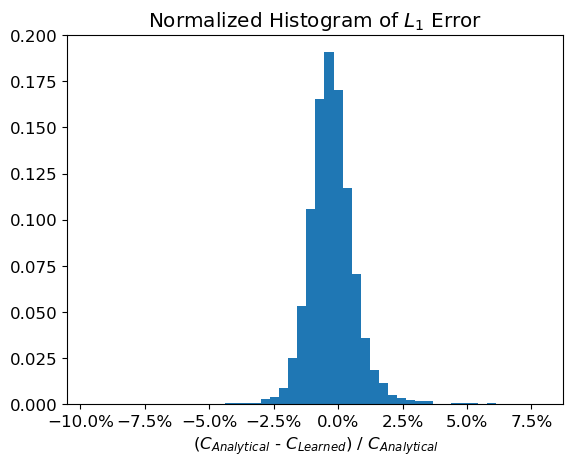

In [21]:
plt.rcParams.update({'font.size': 12})
fig, ax = plt.subplots()
data = df['norm_delta'].values
ax.hist(data, bins=50, weights=np.ones_like(data)/len(data))
ax.set_xlabel('($C_{Analytical}$ - $C_{Learned}$) / $C_{Analytical}$')
ax.set_title('Normalized Histogram of $L_1$ Error')
plt.gca().xaxis.set_major_formatter(PercentFormatter(1))

In [22]:
Reader.read_config('/data/models/lcm/level-05-10-v0/endure.toml')

{'workloads': [{'id': 0, 'z0': 0.25, 'z1': 0.25, 'q': 0.25, 'w': 0.25},
  {'id': 1, 'z0': 0.97, 'z1': 0.01, 'q': 0.01, 'w': 0.01},
  {'id': 2, 'z0': 0.01, 'z1': 0.97, 'q': 0.01, 'w': 0.01},
  {'id': 3, 'z0': 0.01, 'z1': 0.01, 'q': 0.97, 'w': 0.01},
  {'id': 4, 'z0': 0.01, 'z1': 0.01, 'q': 0.01, 'w': 0.97},
  {'id': 5, 'z0': 0.49, 'z1': 0.49, 'q': 0.01, 'w': 0.01},
  {'id': 6, 'z0': 0.49, 'z1': 0.01, 'q': 0.49, 'w': 0.01},
  {'id': 7, 'z0': 0.49, 'z1': 0.01, 'q': 0.01, 'w': 0.49},
  {'id': 8, 'z0': 0.01, 'z1': 0.49, 'q': 0.49, 'w': 0.01},
  {'id': 9, 'z0': 0.01, 'z1': 0.49, 'q': 0.01, 'w': 0.49},
  {'id': 10, 'z0': 0.01, 'z1': 0.01, 'q': 0.49, 'w': 0.49},
  {'id': 11, 'z0': 0.33, 'z1': 0.33, 'q': 0.33, 'w': 0.01},
  {'id': 12, 'z0': 0.33, 'z1': 0.33, 'q': 0.01, 'w': 0.33},
  {'id': 13, 'z0': 0.33, 'z1': 0.01, 'q': 0.33, 'w': 0.33},
  {'id': 14, 'z0': 0.01, 'z1': 0.33, 'q': 0.33, 'w': 0.33}],
 'app': {'name': 'ENDURE'},
 'log': {'name': 'endure-logger',
  'format': '[%(levelname)s][%(asc